Piotr Pawełko, Sid Ali Lariane

In [1]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv
!unzip age-gender-and-ethnicity-face-data-csv.zip

 73% 46.0M/63.2M [00:00<00:00, 261MB/s]
100% 63.2M/63.2M [00:00<00:00, 244MB/s]
Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
ds = pd.read_csv('age_gender.csv')
ds = ds.drop(['img_name'], axis = 1)

In [ ]:
ds['age'].min()

1

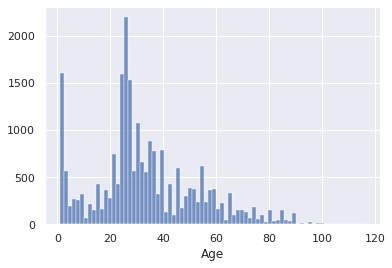

In [ ]:
sns.set_theme()
ax = sns.histplot(data = ds, x= 'age')
ax.set(xlabel='Age', ylabel = '')
plt.show()

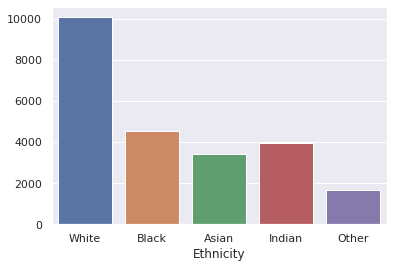

In [ ]:
ethnicitis = ds.groupby(['ethnicity'])['ethnicity'].agg(['count'])
ethnicitis['eth'] = ['White', 'Black', 'Asian', 'Indian', 'Other']
ax = sns.barplot(data = ethnicitis, y= 'count', x= 'eth')
ax.set(xlabel='Ethnicity', ylabel = '')
plt.show()

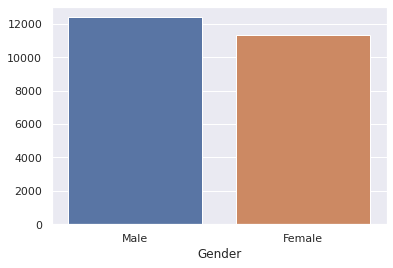

In [ ]:
genders = ds.groupby(['gender'])['gender'].agg(['count'])
genders['gnd'] = ['Male', 'Female']
ax = sns.barplot(data = genders, y= 'count', x= 'gnd')
ax.set(xlabel='Gender', ylabel = '')
plt.show()

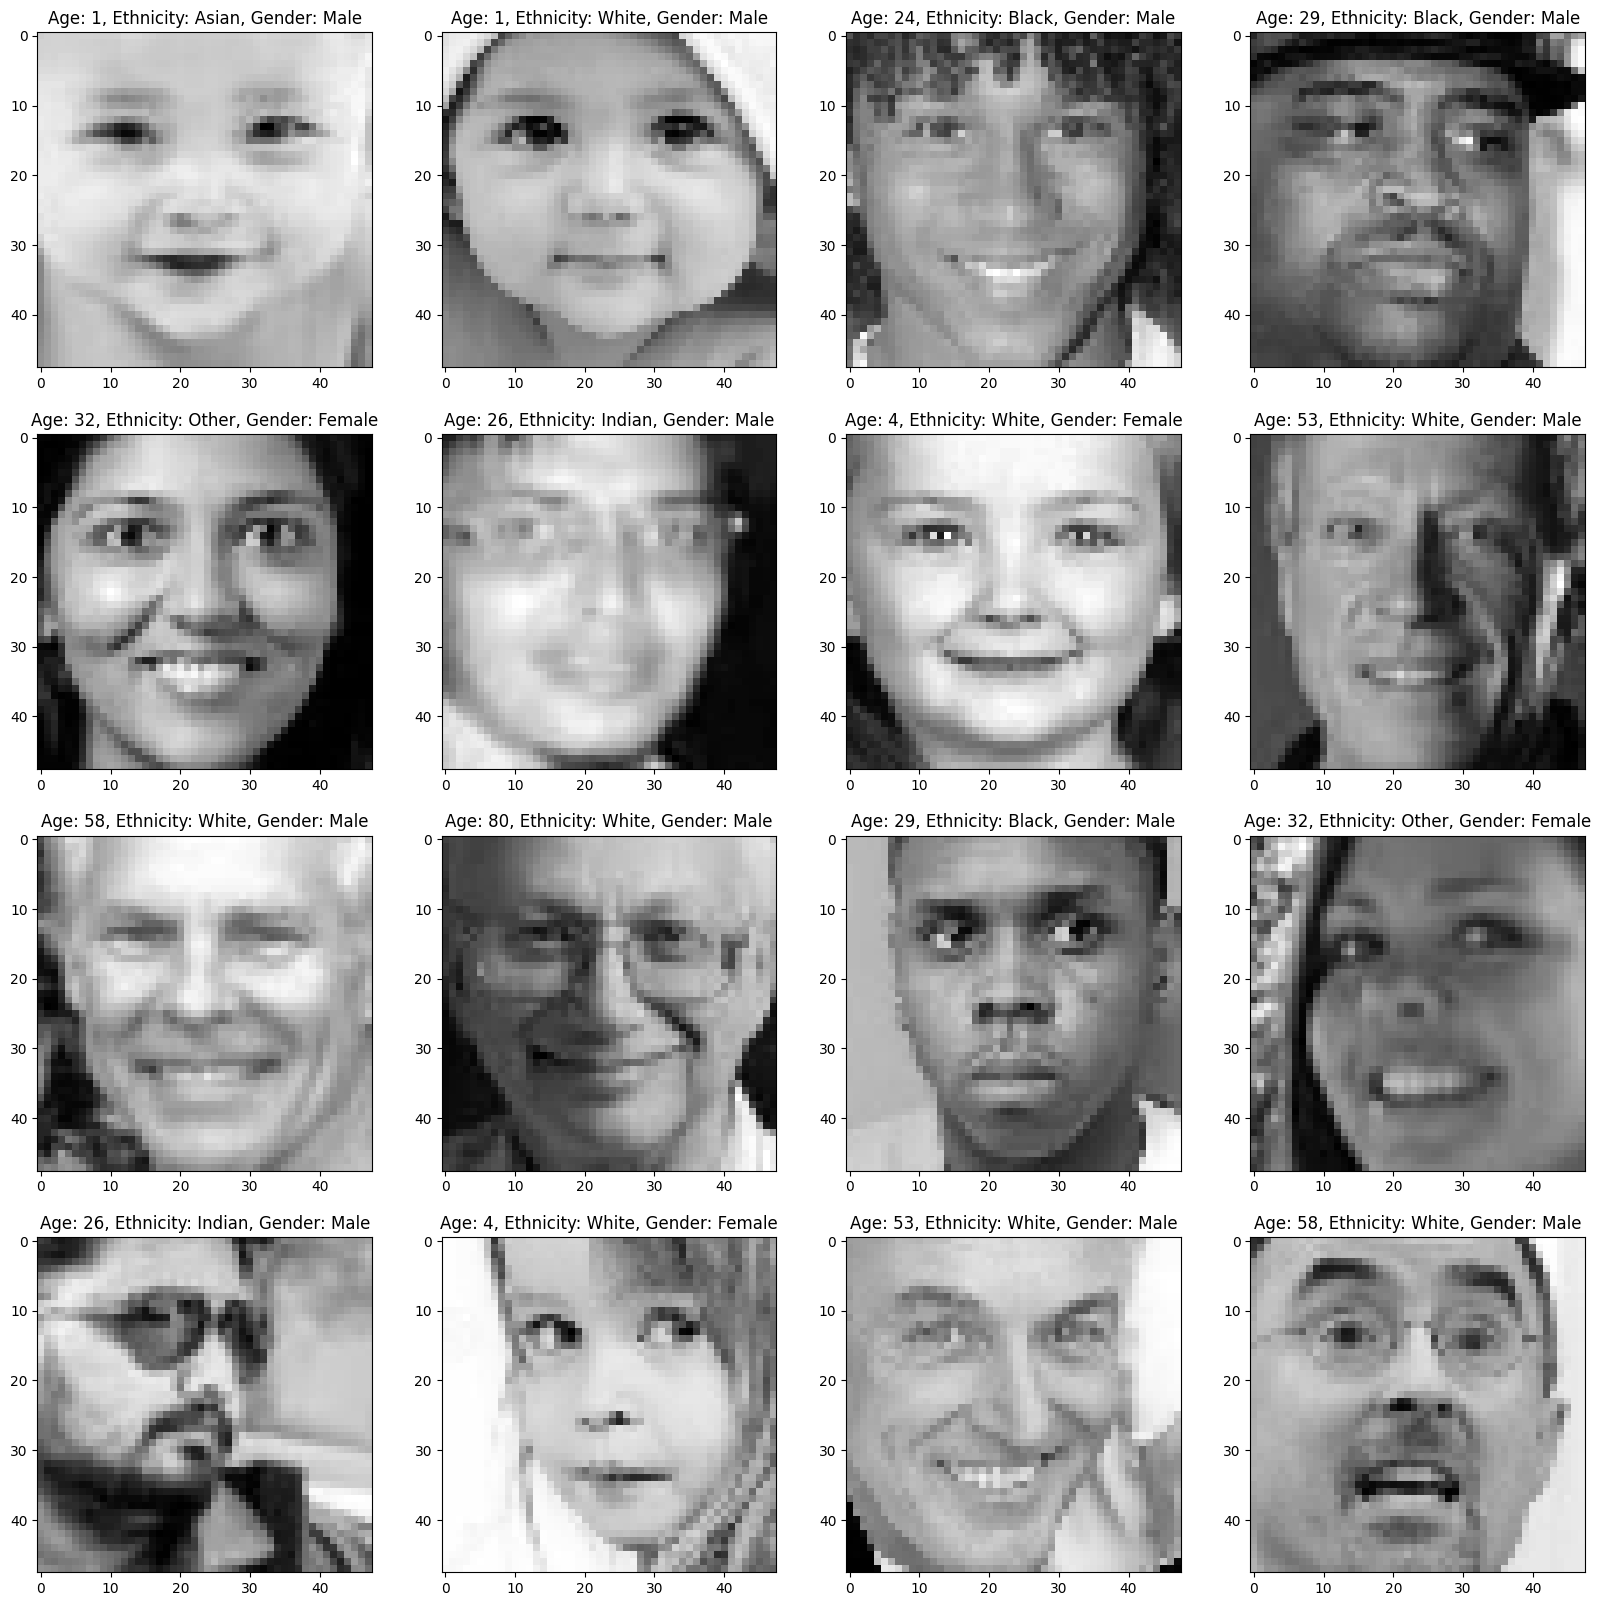

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(4, 4, figsize= (20, 20))

ImageIndex = [5, 400, 5000, 10000, 12000, 8080, 15555, 18888, 20000, 23000, 10004, 12004, 8084, 15557, 18880, 20009, 23009]
k = 0

for i in range(4):
    for j in range(4):
        image = np.fromstring(ds['pixels'][ImageIndex[k]], sep = ' ', dtype = np.uint8)
        image = image.reshape((48,48))
        age = ds.iloc[ImageIndex[k],0]
        if ds.iloc[ImageIndex[k],1] == 0: eth = 'White'
        elif ds.iloc[ImageIndex[k],1] == 1: eth = 'Black'
        elif ds.iloc[ImageIndex[k],1] == 2: eth = 'Asian'
        elif ds.iloc[ImageIndex[k],1] == 3: eth = 'Indian'
        else: eth = 'Other'
        if ds.iloc[ImageIndex[k],2] == 0: gender = 'Male'
        else: gender = 'Female'
        ax[i,j].set_title('Age: {0}, Ethnicity: {1}, Gender: {2}'.format(age, eth, gender))
        ax[i,j].imshow(image, cmap='gray')
        k += 1

In [6]:
import tensorflow as tf
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import data
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, InputLayer, Input, Activation
from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, random_shift
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from sklearn.model_selection import train_test_split

# Data Generator

In [7]:
ds = pd.read_csv('age_gender.csv')
ds = ds.drop(['img_name'], axis = 1)

In [8]:
def augmenation(image, label):

    flip_mask = tf.random.uniform(shape=(tf.shape(image)[0], 1, 1), dtype=tf.float32) > 0.8
    
    image = tf.where(flip_mask, 
                           tf.image.flip_left_right(image), 
                           image)
    
    # Add random noise to the images
    noise_mask = tf.random.uniform(shape=(tf.shape(image)[0], 1, 1), dtype=tf.float32) > 0.8
    noise = tf.random.normal(shape=tf.shape(image), mean=0.03, stddev=0.005)
    image = tf.where(noise_mask,
                           image + noise,
                           image)
    
    return image, label

def DataGenerator(df, batch_size, if_train):
  df_x = []
  for i in df['pixels']:
    image = np.fromstring(i, sep = ' ', dtype = np.uint8).reshape((48,48))
    df_x.append(image)
  df_x = np.array(df_x)
  df_x = df_x / 255.
  df_y = df[['ethnicity', 'gender']].to_numpy()
  df_y_eth = to_categorical(df['ethnicity'].to_numpy(), num_classes=5)
  df_y_gender = to_categorical(df['gender'].to_numpy(), num_classes=2)
  df_y_age = df['age'].to_numpy()
  i = 0

  df_x = tf.convert_to_tensor(df_x, dtype=tf.float32)
  df_y_age = tf.convert_to_tensor(df_y_age, dtype=tf.float32)
  df_y_eth = tf.convert_to_tensor(df_y_eth, dtype=tf.float32)
  df_y_gender = tf.convert_to_tensor(df_y_gender, dtype=tf.float32)
  dataset = tf.data.Dataset.from_tensor_slices((df_x, (df_y_age, df_y_eth, df_y_gender)))
  batched_dataset = dataset.batch(batch_size)
  if if_train == True:
    batched_dataset = batched_dataset.map(augmenation)
  return batched_dataset

In [9]:
train, test = train_test_split(ds, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.2, random_state=42)

train_dataset= DataGenerator(train, 32, True)
valid_dataset= DataGenerator(valid, 32, False)
test_dataset= DataGenerator(test, 32, False)

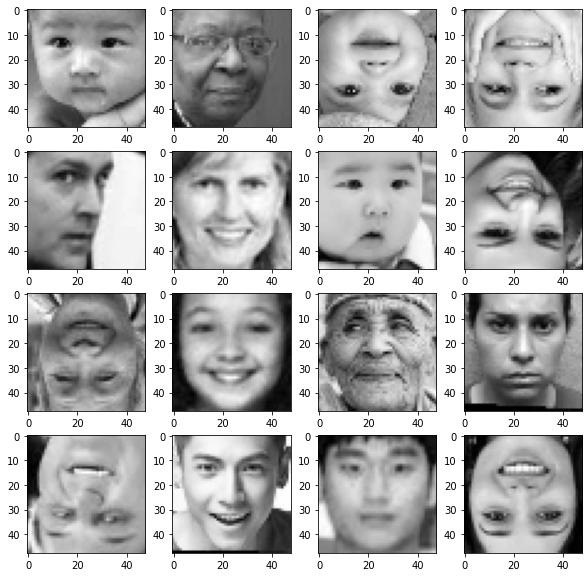

In [10]:
import tensorflow_datasets as tfds
d = train_dataset.take(1)
_,axs = plt.subplots(4,4, figsize=(10,10))
axs = axs.flatten()
for batch_image, batch_label in tfds.as_numpy(d):
  for j in range(16):
    axs[j].imshow(batch_image[j], cmap='gray')
plt.show()

# Model

In [11]:
def multilabel_model():
  x_input = Input(shape = (48, 48, 1))
  x = Conv2D(256, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_input)
  x = Conv2D(128, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(pool_size= (2,2))(x)
  x = Dropout(0.25)(x)

  # Age
  x_age = Conv2D(32, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_input)
  x_age = MaxPooling2D(pool_size= (2,2))(x_age)
  x_age = Dropout(0.25)(x_age)

  x_age = Conv2D(64, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_age)
  x_age = MaxPooling2D(pool_size= (2,2))(x_age)
  x_age = Dropout(0.25)(x_age)

  x_age = Conv2D(128, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_age)
  x_age = MaxPooling2D(pool_size= (2,2))(x_age)
  x_age = Dropout(0.5)(x_age)

  x_age = Flatten()(x_age)
  x_age = Dense(128, activation = 'relu')(x_age)
  x_age = Dropout(0.5)(x_age)

  x_age = Dense(64, activation = 'relu')(x_age)
  x_age = Dropout(0.25)(x_age)

  output_age = Dense(1, activation = None, name='output_age')(x_age)


  # ETHNICITY
  x_ethnicity = Conv2D(128, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_input)
  #x_ethnicity = BatchNormalization(axis=-1)(x_ethnicity)
  x_ethnicity = MaxPooling2D(pool_size= (2,2))(x_ethnicity)
  x_ethnicity = Dropout(0.5)(x_ethnicity)

  x_ethnicity = Conv2D(256, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_ethnicity)
  #x_ethnicity = BatchNormalization(axis=-1)(x_ethnicity)
  x_ethnicity = MaxPooling2D(pool_size= (2,2))(x_ethnicity)
  x_ethnicity = Dropout(0.25)(x_ethnicity)

  x_ethnicity = Conv2D(512, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_ethnicity)
  #x_ethnicity = BatchNormalization(axis=-1)(x_ethnicity)
  x_ethnicity = MaxPooling2D(pool_size= (2,2))(x_ethnicity)
  x_ethnicity = Dropout(0.5)(x_ethnicity)

  x_ethnicity = Flatten()(x_ethnicity)
  x_ethnicity = Dense(512, activation = 'relu')(x_ethnicity)
  x_ethnicity = Dropout(0.5)(x_ethnicity)

  x_ethnicity = Dense(256, activation = 'relu')(x_ethnicity)
  x_ethnicity = Dropout(0.5)(x_ethnicity)

  output_ethnicity = Dense(5, activation = 'softmax', name='output_ethnicity')(x_ethnicity)
  
  # GENDER
  x_gender = Conv2D(16, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_input)
  x_gender = MaxPooling2D(pool_size= (2,2))(x_gender)
  x_gender = Dropout(0.25)(x_gender)

  x_gender = Conv2D(32, kernel_size=(3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(x_gender)
  x_gender = MaxPooling2D(pool_size= (2,2))(x_gender)
  x_gender = Dropout(0.25)(x_gender)

  x_gender = Flatten()(x_gender)
  x_gender = Dense(32, activation = 'relu')(x_gender)
  x_gender = Dropout(0.25)(x_gender)

  x_gender = Dense(32, activation = 'relu')(x_gender)
  x_gender = Dropout(0.25)(x_gender)

  output_gender = Dense(2, activation = 'softmax', name='output_gender')(x_gender)

  model = Model(inputs=x_input, outputs = [output_age, output_ethnicity, output_gender])
  return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 48, 48, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 48, 48, 128)  1280        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 24, 24, 32)  0           ['conv2d_12[0][0]']              
 )                                                                                          

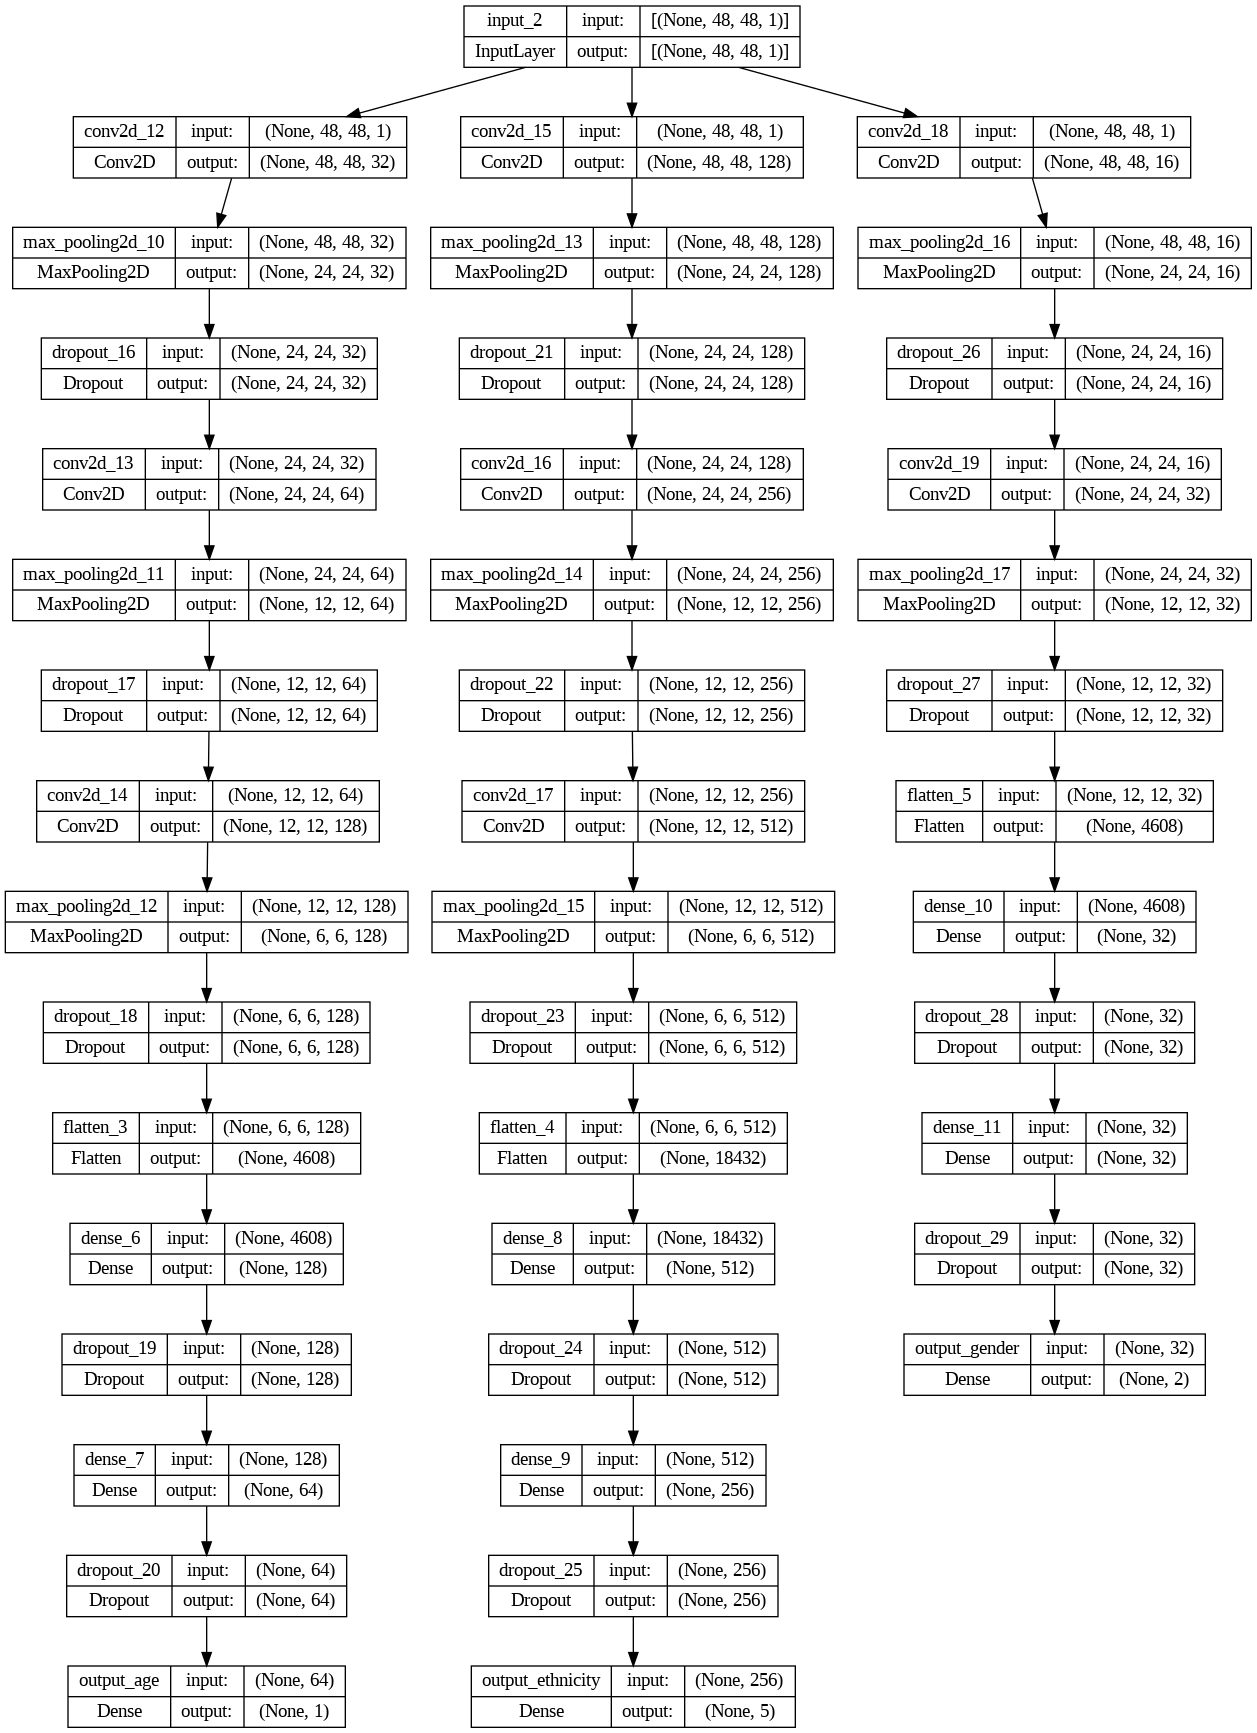

In [13]:
model = multilabel_model()
model.summary()
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

In [34]:
model = multilabel_model()
model.compile(optimizer='adam',
              loss={'output_age': 'mse', 'output_ethnicity': 'categorical_crossentropy', 'output_gender': 'categorical_crossentropy'},
              metrics={'output_age': tf.keras.metrics.RootMeanSquaredError(), 'output_ethnicity': 'accuracy', 'output_gender': 'accuracy'})
history_model = model.fit(train_dataset, validation_data=valid_dataset, epochs=50)

Epoch 1/50
475/475 [==============================] - 14s 27ms/step - loss: 469.8895 - output_age_loss: 467.8882 - output_ethnicity_loss: 1.4005 - output_gender_loss: 0.6007 - output_age_root_mean_squared_error: 21.6307 - output_ethnicity_accuracy: 0.4523 - output_gender_accuracy: 0.6675 - val_loss: 467.1889 - val_output_age_loss: 465.4227 - val_output_ethnicity_loss: 1.3049 - val_output_gender_loss: 0.4614 - val_output_age_root_mean_squared_error: 21.5737 - val_output_ethnicity_accuracy: 0.4719 - val_output_gender_accuracy: 0.7915
Epoch 2/50
475/475 [==============================] - 12s 26ms/step - loss: 366.5382 - output_age_loss: 364.8043 - output_ethnicity_loss: 1.2727 - output_gender_loss: 0.4614 - output_age_root_mean_squared_error: 19.0998 - output_ethnicity_accuracy: 0.5017 - output_gender_accuracy: 0.7810 - val_loss: 322.3178 - val_output_age_loss: 320.7281 - val_output_ethnicity_loss: 1.1953 - val_output_gender_loss: 0.3944 - val_output_age_root_mean_squared_error: 17.9089 -

In [ ]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history_model.history['output_age_root_mean_squared_error'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history_model.history['val_output_age_root_mean_squared_error'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Age Root Mean Squared Error',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history_model.history['output_ethnicity_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history_model.history['val_output_ethnicity_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Ethnicity Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history_model.history['output_gender_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history_model.history['val_output_gender_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Gender Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history_model.history['loss'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history_model.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [ ]:
loss = model.evaluate(test_dataset)

149/149 [==============================] - 2s 14ms/step - loss: 84.7732 - output_age_loss: 83.8621 - output_ethnicity_loss: 0.6571 - output_gender_loss: 0.2540 - output_age_root_mean_squared_error: 9.1576 - output_ethnicity_accuracy: 0.7697 - output_gender_accuracy: 0.8897


In [36]:
age_predicted, ethnicity_predicted, gender_predicted = model.predict(test_dataset)

149/149 [==============================] - 1s 7ms/step


In [37]:
age_result = np.round(age_predicted)
print(ethnicity_predicted)
result_ethnicity = np.zeros_like(ethnicity_predicted)
result_ethnicity[np.arange(ethnicity_predicted.shape[0]), np.argmax(ethnicity_predicted, axis=1)] = 1
print(result_ethnicity)
result_ethnicity = np.argmax(result_ethnicity, axis=1)
result_ethnicity = result_ethnicity.reshape(-1, 1)
print(result_ethnicity)
gender_predicted
print(gender_predicted)
result_gender = np.zeros_like(gender_predicted)
result_gender[np.arange(gender_predicted.shape[0]), np.argmax(gender_predicted, axis=1)] = 1
print(result_gender)
result_gender = np.argmax(result_gender, axis=1)
result_gender = result_gender.reshape(-1, 1)
print(result_gender)

[[2.1488185e-01 1.9445547e-01 6.9283135e-02 2.7559927e-01 2.4578030e-01]
 [1.0775613e-02 9.6793592e-01 2.3067063e-03 1.2237175e-02 6.7446497e-03]
 [4.3687922e-01 1.1211176e-01 6.0597777e-02 1.4112356e-01 2.4928768e-01]
 ...
 [1.6654693e-02 1.6237393e-02 3.8010851e-03 9.0792131e-01 5.5385482e-02]
 [9.8522204e-01 6.2676501e-03 1.7153415e-04 5.7895291e-03 2.5493361e-03]
 [9.3183130e-01 1.7005039e-03 1.5604261e-03 2.9679565e-02 3.5228338e-02]]
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[3]
 [1]
 [0]
 ...
 [3]
 [0]
 [0]]
[[0.07394189 0.9260582 ]
 [0.9393596  0.06064045]
 [0.3376693  0.66233075]
 ...
 [0.18031232 0.81968766]
 [0.82524824 0.17475179]
 [0.9800642  0.01993575]]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
ethnicity_report = classification_report(test['ethnicity'], result_ethnicity)
print(ethnicity_report)
gender_report = classification_report(test['gender'], result_gender)
print(gender_report)
print('R2: ', r2_score(test['age'], age_result))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      2047
           1       0.83      0.82      0.82       904
           2       0.82      0.78      0.80       657
           3       0.72      0.65      0.68       804
           4       0.62      0.05      0.09       329

    accuracy                           0.77      4741
   macro avg       0.75      0.64      0.64      4741
weighted avg       0.76      0.77      0.74      4741

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      2468
           1       0.85      0.92      0.89      2273

    accuracy                           0.89      4741
   macro avg       0.89      0.89      0.89      4741
weighted avg       0.89      0.89      0.89      4741

R2:  0.753453365419541


In [40]:
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
test['pred_age'] = age_result
test['pred_ethnicity'] = result_ethnicity
test['pred_gender'] = result_gender

In [61]:
test = test.reset_index()

In [63]:
test.sample(6)

,index,age,ethnicity,gender,pixels,pred_age,pred_ethnicity,pred_gender
4008,409,1,0,0,254 252 238 216 207 209 209 208 209 209 211 21...,3.0,0,1
1527,8310,26,0,1,68 61 47 68 66 66 67 56 64 179 202 208 213 217...,26.0,0,1
3865,20750,60,0,1,62 53 52 51 55 57 70 81 91 100 99 97 101 102 9...,50.0,0,1
2742,5657,25,1,0,116 114 40 25 35 53 89 114 128 144 162 175 174...,32.0,0,0
2427,6013,25,3,1,200 198 199 188 136 75 54 33 24 25 41 103 152 ...,27.0,3,1
2323,4874,24,3,0,8 6 20 28 73 34 45 25 62 180 177 180 183 170 1...,26.0,3,0


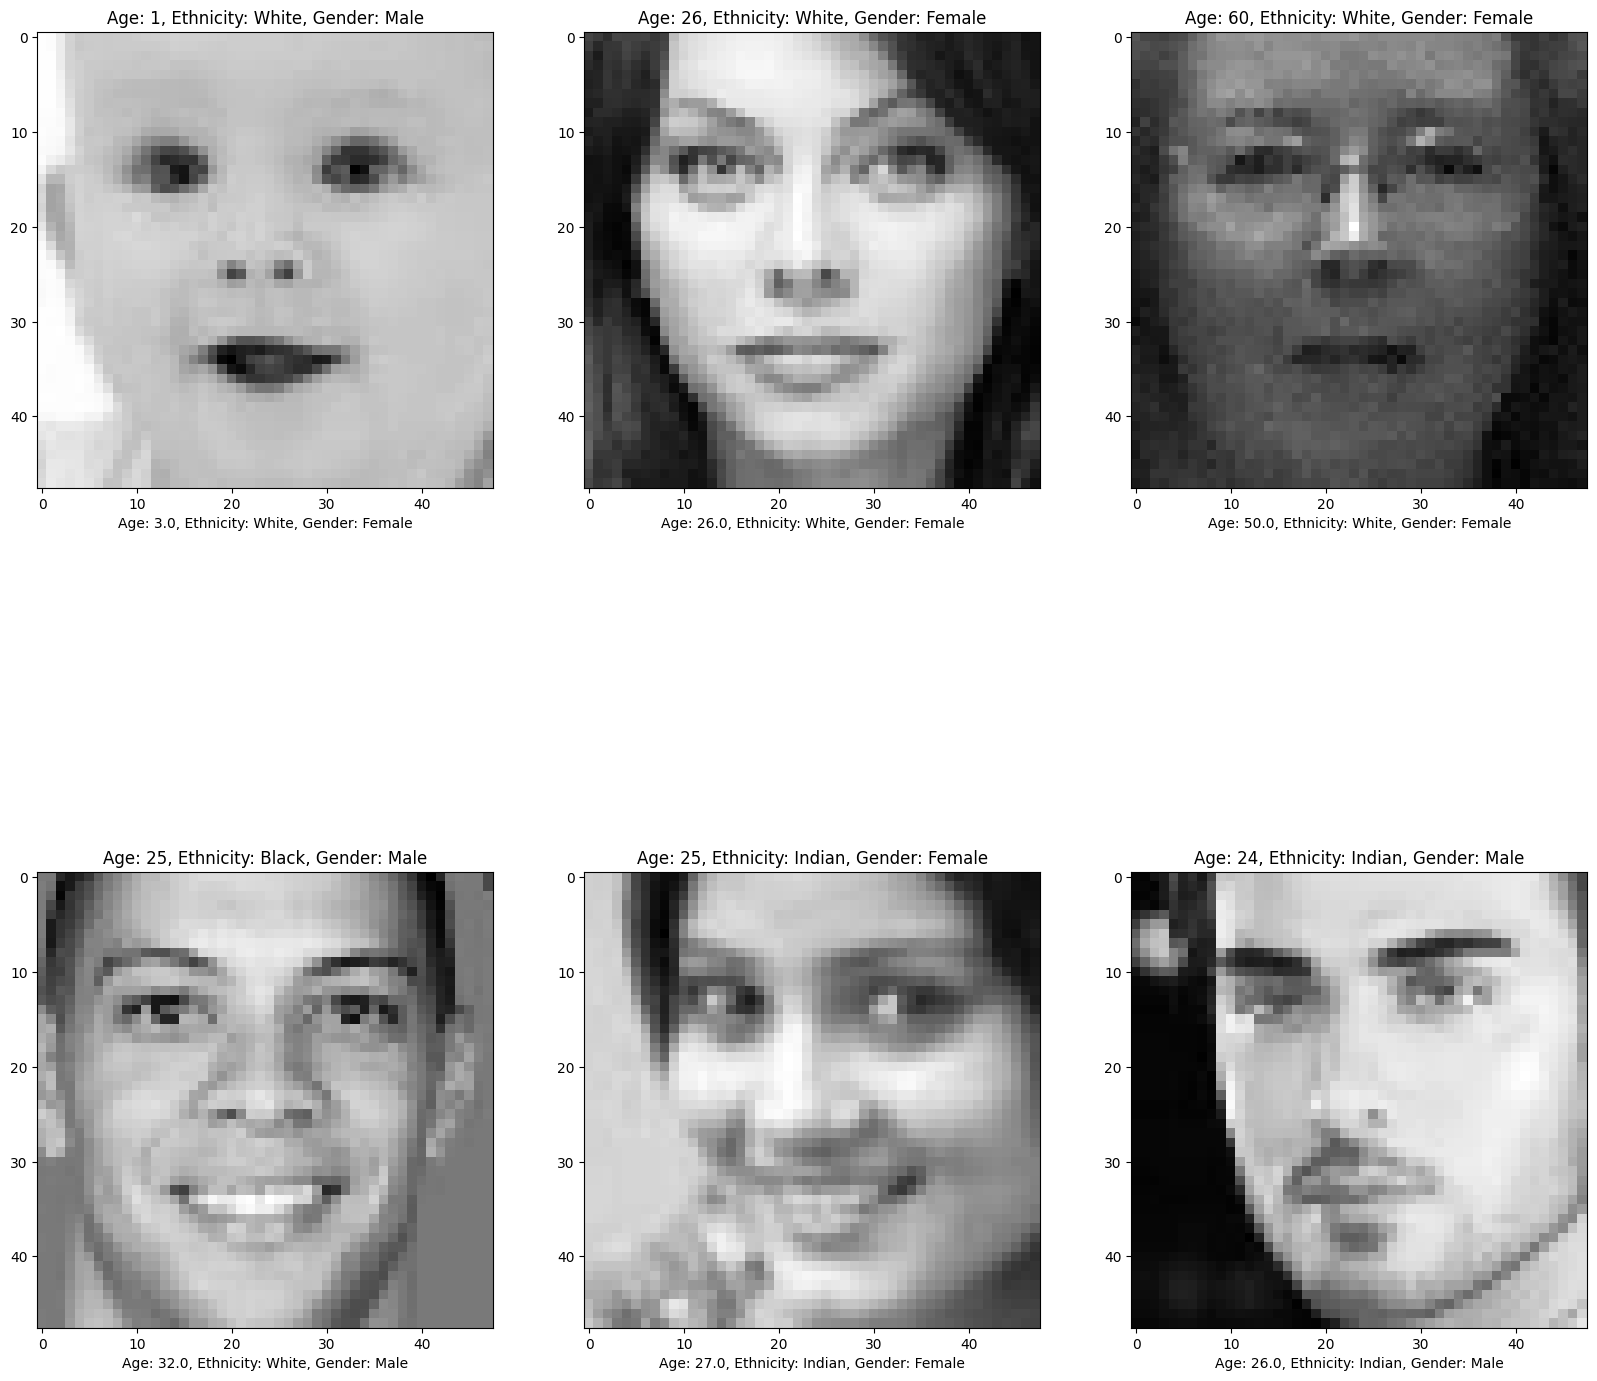

In [87]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(2, 3, figsize= (20, 20))

ImageIndex = [4008, 1527, 3865, 2742, 2427, 2323]
k = 0

for i in range(2):
    for j in range(3):
        image = np.fromstring(test['pixels'][ImageIndex[k]], sep = ' ', dtype = np.uint8)
        image = image.reshape((48,48))
        age = test.iloc[ImageIndex[k],1]
        pred_age = test.iloc[ImageIndex[k],5]
        if test.iloc[ImageIndex[k],2] == 0: eth = 'White'
        elif test.iloc[ImageIndex[k],2] == 1: eth = 'Black'
        elif test.iloc[ImageIndex[k],2] == 2: eth = 'Asian'
        elif test.iloc[ImageIndex[k],2] == 3: eth = 'Indian'
        else: eth = 'Other'
        if test.iloc[ImageIndex[k],6] == 0: pred_eth = 'White'
        elif test.iloc[ImageIndex[k],6] == 1: pred_eth = 'Black'
        elif test.iloc[ImageIndex[k],6] == 2: pred_eth = 'Asian'
        elif test.iloc[ImageIndex[k],6] == 3: pred_eth = 'Indian'
        else: pred_eth = 'Other'
        if test.iloc[ImageIndex[k],3] == 0: gender = 'Male'
        else: gender = 'Female'
        if test.iloc[ImageIndex[k],7] == 0: pred_gender = 'Male'
        else: pred_gender = 'Female'
        ax[i,j].set_title('Age: {0}, Ethnicity: {1}, Gender: {2}'.format(age, eth, gender))
        ax[i,j].set_xlabel('Age: {0}, Ethnicity: {1}, Gender: {2}'.format(pred_age, pred_eth, pred_gender))
        ax[i,j].imshow(image, cmap='gray')
        k += 1